This code is to fit a spectrum as the sum of two atmosphere models (a spot and a surface).

To do:
<br /> -Masking out bad regions a la Mann+2013
<br /> -Testing just NIR data
<br /> -Additional flux calibration corrections?

In [1]:
from astropy.modeling import models
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u

from scipy import interpolate
from scipy import stats
from scipy import optimize

import numpy as np

from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

import matplotlib.pyplot as plt

from multiprocessing import Pool

from emcee import EnsembleSampler
import emcee
import corner
import random

from gaussfold import gaussfold as gf
from IPython.display import display, Math

import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19

# define the model
ext = F19(Rv=3.1)
import multiprocessing
import os
from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import cpu_count


In [2]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize'] = 9

In [3]:
whoami = os.getlogin()
#whoami = 'mannaw'
#whoami = 'andrewmann'

In [4]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a1, b1, c1, a2, b2, c2, AV, loff_o, loff_ir, f = theta
    if AV > 1.5 or AV < 0.3 or (loff_o < -3) or (loff_o > 3) or (loff_ir < -3) or (loff_ir > 3) or (Tspot < 2000) or (Tspot > 3900) or (Tsurf < 2000) or (Tsurf > 3900) or fS < 0.0 or fS > 0.995 or f < 0 or f > 0.1 or Tspot>(Tsurf-50) or a1>1.2 or a1<0.8 or b1>1.2 or b1<0.8 or c1>1.2 or c1<0.8 or a2>0.01 or a2<-0.01 or b2>0.01 or b2<-0.01 or c2>0.01 or c2<-0.01:
        return -np.inf
    ## prior on Tsurf
    s_squared = np.square(70)
    p1 = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(3500.-Tsurf) / (2. * s_squared)) 
    s_squared = np.square(0.05)
    p2 = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(0.7-AV) / (2. * s_squared)) 
    
    s_squared = np.square(3.7e-5)
    p3 = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(a2) / (2. * s_squared)) 
    s_squared = np.square(6.5e-6)
    p4 = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(b2) / (2. * s_squared)) 
    s_squared = np.square(1.8e-6)
    p5 = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(c2) / (2. * s_squared))
    return np.log(p1+p2+p3+p4+p5)

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a1, b1, c1, a2, b2, c2, AV, loff_o, loff_ir, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav[np.where((obstype == 1) | (obstype == 2))] + loff_o
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift_o = interpfunc(newwav)
    newwav = wav[np.where((obstype == 3))] + loff_ir
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift_ir = interpfunc(newwav)
    
    modelspec_smooth = np.array(wav)
    modelspec_smooth[np.where((obstype == 1) | (obstype == 2))] = np.array(modelspec_shift_o)
    modelspec_smooth[np.where((obstype == 3))] = np.array(modelspec_shift_ir)
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    
    norm1 = a1+a2*(wav[np.where(obstype == 1)]-np.mean(wav[np.where(obstype == 1)]))
    norm2 = b1+b2*(wav[np.where(obstype == 2)]-np.mean(wav[np.where(obstype == 2)]))
    norm3 = c1+c2*(wav[np.where(obstype == 3)]-np.mean(wav[np.where(obstype == 3)]))
    #print(norm1,norm2,norm3)
    obsspec_norm[np.where(obstype == 1)]*=norm1
    obsspec_norm[np.where(obstype == 2)]*=norm2
    obsspec_norm[np.where(obstype == 3)]*=norm3
    obsspec_err_norm[np.where(obstype == 1)]*=norm1
    obsspec_err_norm[np.where(obstype == 2)]*=norm2
    obsspec_err_norm[np.where(obstype == 3)]*=norm3    
    ## due to edge effects, we need to trim the first and last ~20 points
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    ## what if we just removed the 20 worst points instead?
    tmp = np.sort(p)
    #print(tmp)
    #print(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)])
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.02)):np.size(tmp)]))
    #output = np.sum(np.log(p[20:np.size(modelspec_norm)-20]))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [5]:
def ln_priorOPT(theta):
    Tsurf, Tspot, fS, a, b, AV, loff, f = theta
    if AV > 1.5 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 2000) or (Tspot > 3900) or (Tsurf < 2000) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100):
        return -np.inf
    s_squared = np.square(70)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(3540.-Tsurf) / (2. * s_squared)) 
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihoodOPT(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a, b, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    obsspec_norm[np.where(obstype == 1)]*=a
    obsspec_norm[np.where(obstype == 2)]*=b
    obsspec_err_norm[np.where(obstype == 1)]*=a
    obsspec_err_norm[np.where(obstype == 2)]*=b
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    tmp = np.sort(p)
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)]))
    return output

def ln_posteriorOPT(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_priorOPT(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihoodOPT(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [6]:
def ln_priorNIR(theta):
    Tsurf, Tspot, fS, a, AV, loff, f = theta
    if AV > 1.5 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 2000) or (Tspot > 3900) or (Tsurf < 2000) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100):
        return -np.inf
    s_squared = np.square(70)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(3540.-Tsurf) / (2. * s_squared)) 
    return 0

def ln_likelihoodNIR(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    Tsurf, Tspot, fS, a, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    obsspec_norm*=a
    obsspec_err_norm*=a
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    tmp = np.sort(p)
    output = np.sum(np.log(tmp[int(np.round(np.size(tmp)*0.01)):np.size(tmp)]))
    return output

def ln_posteriorNIR(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    ln_p = ln_priorNIR(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihoodNIR(theta, modelteff, modelspectra, wav, obsspec, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

(9782,)
(1, 8472)
(1, 8317)
Filename: /Users/mannaw/Dropbox/Radii/Models_K233_Feb2020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 13650065E, 65E, 65E, 65E, 65E, 65E]   
500.0 6900.0
running full spectrum
if this is inf, we have a problem:
14020.805817493636
initializing walkers: (if you see a lot if inf, break this)
restoring data from Lowres_backend2.h5


100%|██████████| 200000/200000 [14:36:14<00:00,  3.80it/s]   


done


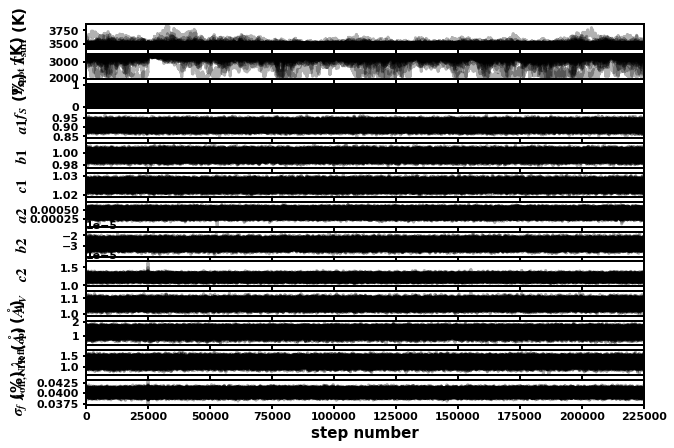

(2250000, 13)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------
$T_{\rm{surf}}$ (K) 3491.4602446066992
$T_{\rm{spot}}$ (K) 3428.5096562022363
$f_S$ (%) 72.76213595609578
$a1$ 0.9131134863234386
$b1$ 0.9960735966693519
$c1$ 1.0248188161399738
$a2$ 0.00044392797812912977
$b2$ -2.8485123358731737e-05
$c2$ 1.2163242371793246e-05
$A_V$ 1.062766735251051
$\lambda_{\rm{off,opt}}$ ($\AA$) 1.35984658158067
$\lambda_{\rm{off,NIR}}$ ($\AA$) 1.2545348871388449
$\sigma_f$ (%) 0.04012660088787571
[ 3.49146024e+03  3.42850966e+03  7.27621360e-01  9.13113486e-01
  9.96073597e-01  1.02481882e+00  4.43927978e-04 -2.84851234e-05
  1.21632424e-05  1.06276674e+00  1.35984658e+00  1.25453489e+00
  4.01266009e-02]


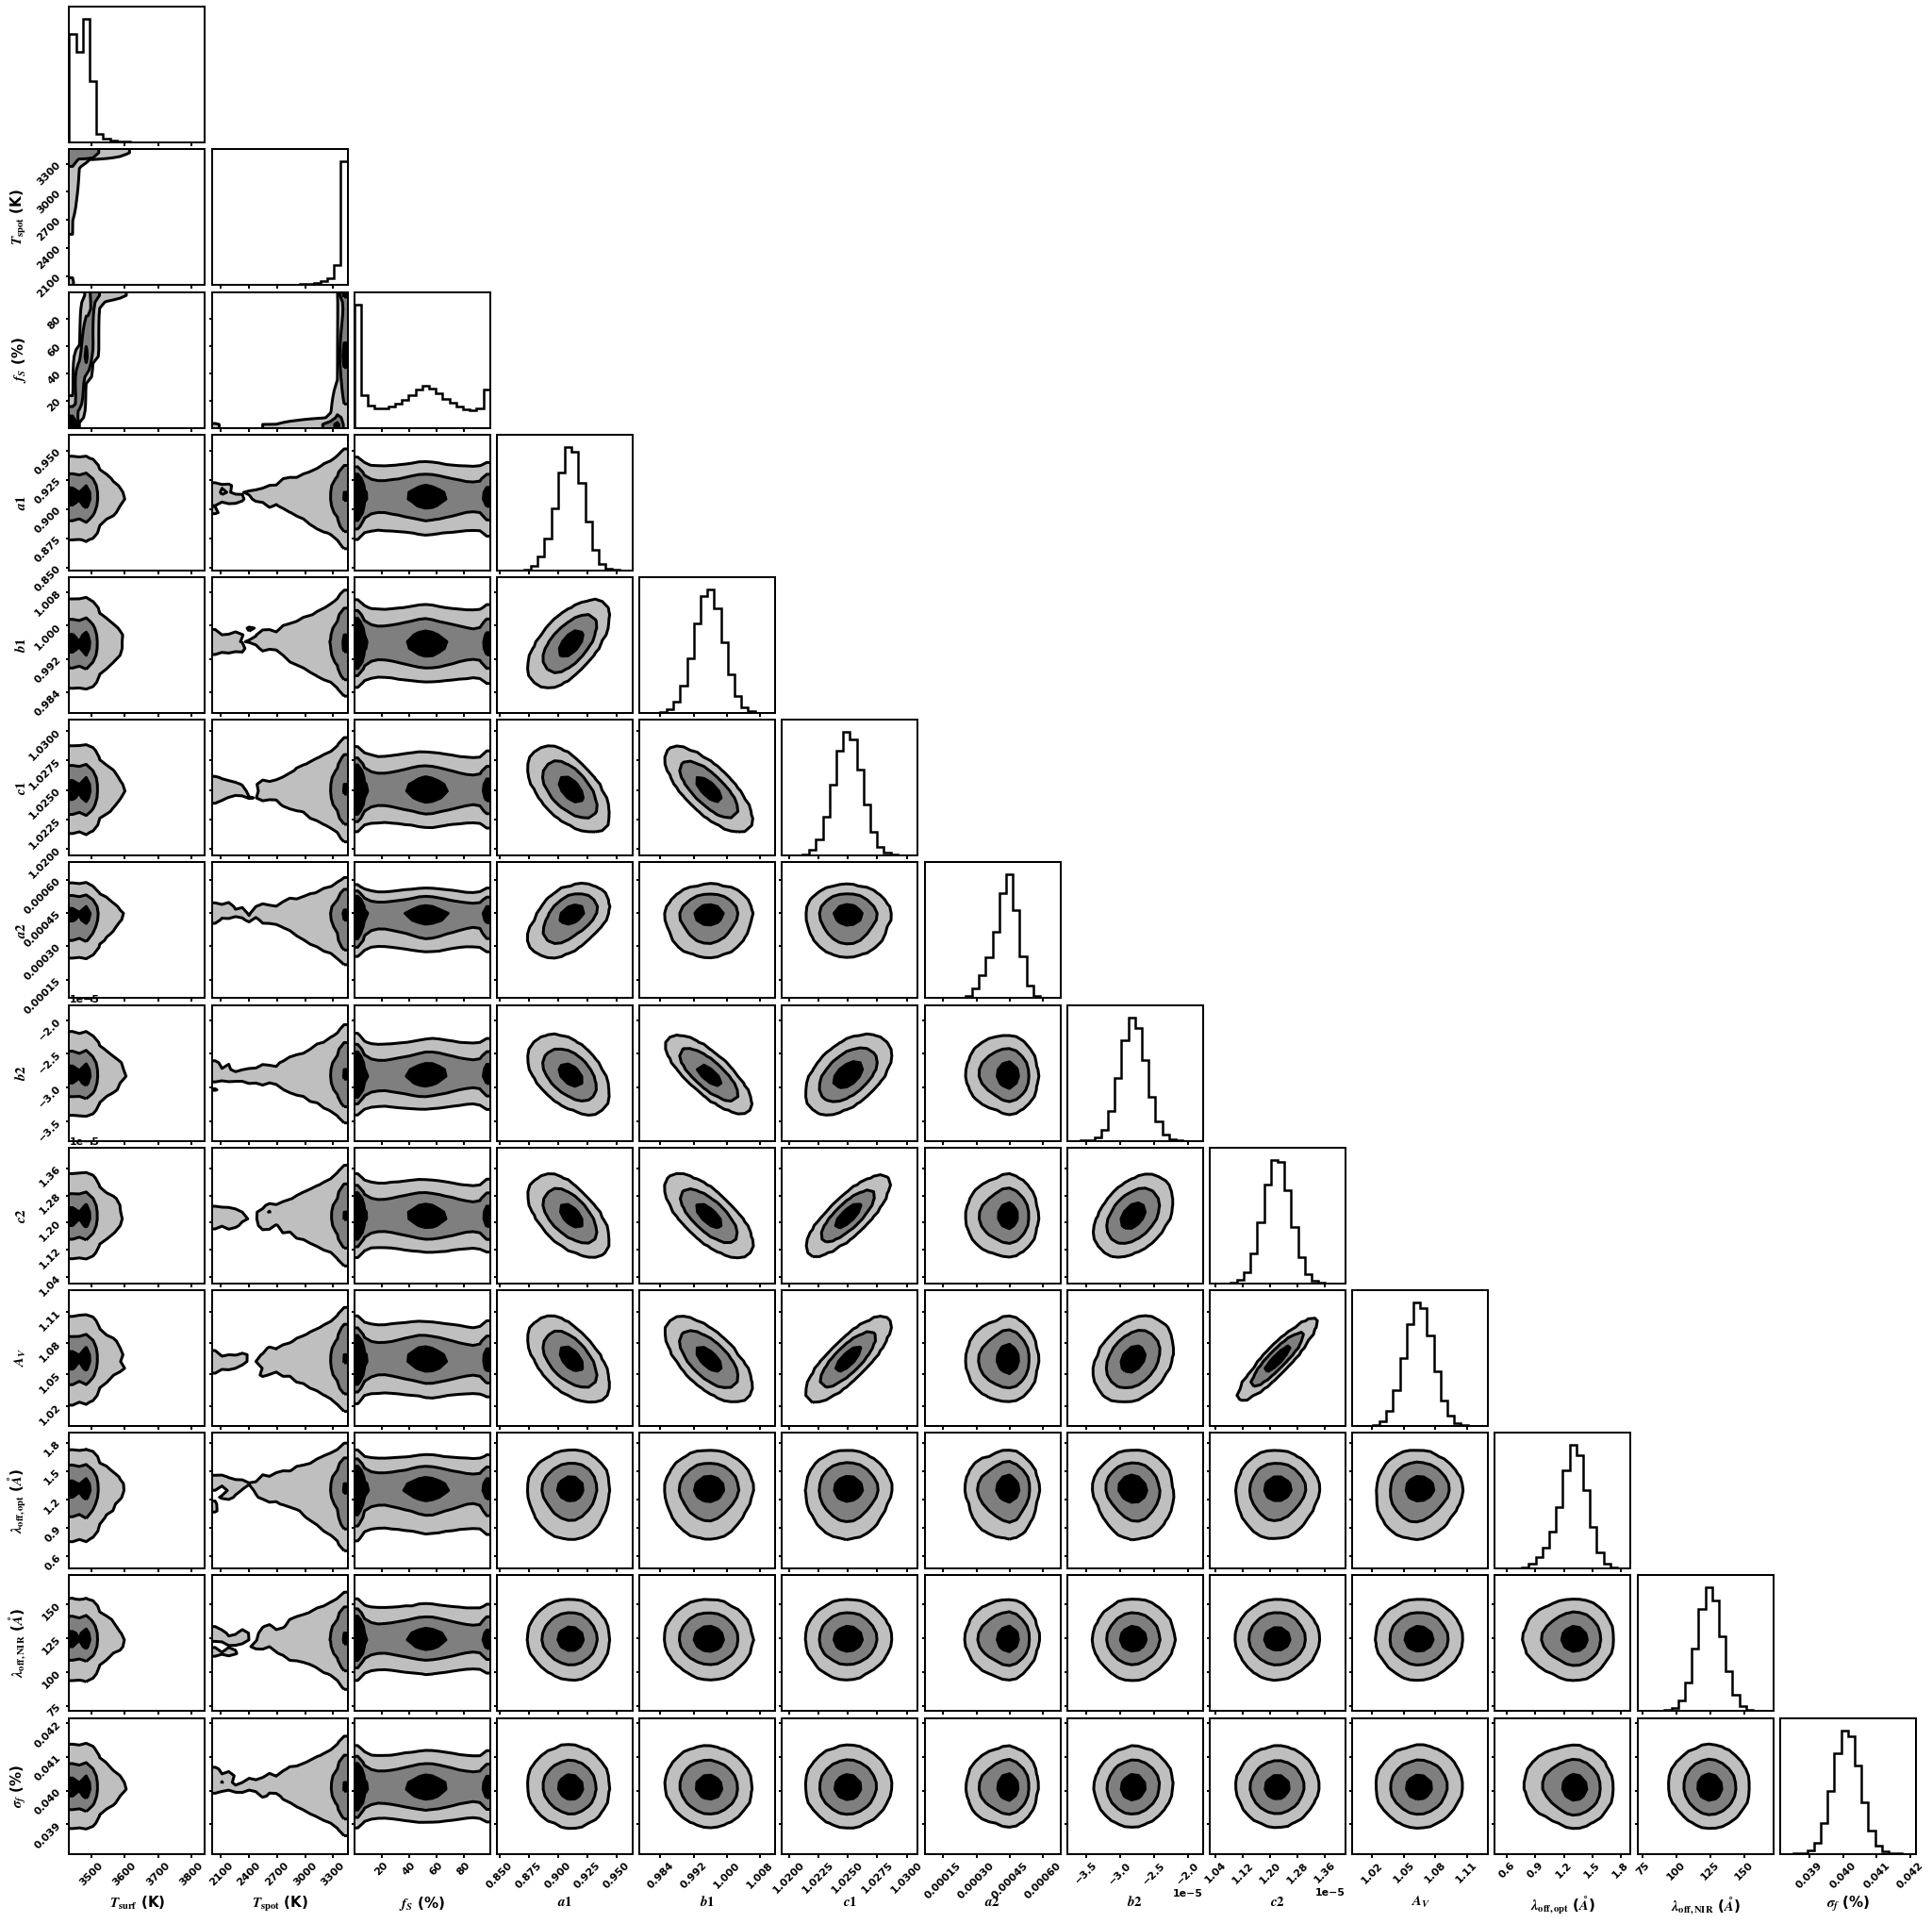

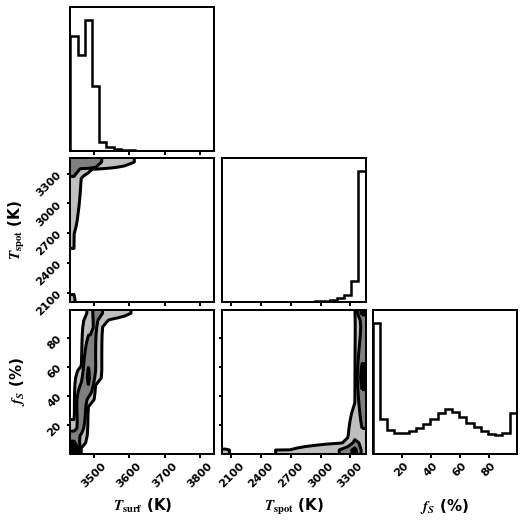

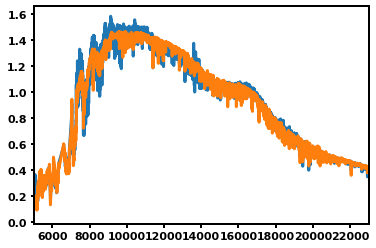

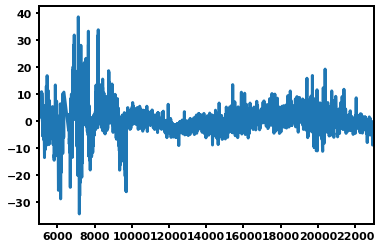

In [9]:
nums = [2,3,4,5,0,1]
startnew = False
#nums = [5,4,2,3,1,0]
# 0 kinda failed, let's ignore it for now. 
nums = [2]
nsteps = 200000
burn =    75000
thin = 10

for num in nums:

    ## 1 == full spec, no mask
    ## 2 = full spec, optical mask
    ## 3 = NIR only
    ## 4 = optical only, no mask
    ## 5 = optical only, optical mask
    if num == 1:
        mask_optical = False
        nir_only = False
        optical_only = False
        modtype = 'k233'
    if num == 2:
        mask_optical = True
        nir_only = False
        optical_only = False
        modtype = 'k233'
    if num == 3:
        mask_optical = False
        nir_only = True
        optical_only = False
        modtype = 'k233'
    if num == 4:
        mask_optical = False
        nir_only = False
        optical_only = True
        modtype = 'k233'
    if num == 5:
        mask_optical = True
        nir_only = False
        optical_only = True
        modtype = 'k233'
    if num == 0:
        mask_optical = True
        nir_only = False
        optical_only = False
        modtype = 'old'

    ## read in data
    obswav,obsspec,obserr,obstype = np.loadtxt('rawspec.txt',unpack=True,skiprows=1)
    obserr[np.where(obstype == 3)] = 1.25*np.array(obserr[np.where(obstype == 3)])
#     plt.plot(obswav,obsspec)
#     l1 = np.where(obstype == 1)
#     plt.plot(obswav[l1],obsspec[l1])
#     l2 = np.where(obstype == 2)
#     plt.plot(obswav[l2],obsspec[l2])
#     l3 = np.where(obstype == 3)
#     plt.plot(obswav[l3],obsspec[l3])
#     plt.xlim(4000,20000)
#     plt.tight_layout()
#     plt.show()

    ## this trims the bad region of the SpeX data (noisy)
    #l4 = np.where((obswav > 4000) & (obswav<24000) & ((obswav > 8000)|(obstype<3)) & (obsspec > 0))
    #opticalspec = obsspec[l4]
    #opticalwav = obswav[l4]
    #opticalerr = obserr[l4]
    print(np.shape(obswav))
    l5 = np.where((obswav > 4200) & (obswav<23500) & (obsspec/obserr > 10))
    print(np.shape(l5))
    if mask_optical: ## if we want to cut the annoying region around 6300-6600
        l5 = np.where((obswav > 4200) & (obswav<23500) & (obsspec/obserr > 10) & ((obswav > 6600)|(obswav<6350)) & ((obswav > 6153)|(obswav<6056)) & ((obswav > 7025)|(obswav<6915)) & ((obswav > 7580)|(obswav<7700))   )
    if nir_only:
        l5 = np.where((obstype == 3)&(obswav<23500))
    if optical_only:
        l5 = np.where((obstype < 3)&(obswav > 4200))
    if optical_only & mask_optical:
        l5 = np.where((obstype<3) & (obswav > 4200) & (obswav<23500) & (obsspec/obserr > 10) & ((obswav > 6600)|(obswav<6350)) & ((obswav > 6153)|(obswav<6056)) & ((obswav > 7025)|(obswav<6915)) & ((obswav > 7580)|(obswav<7700))   )
    print(np.shape(l5))
    ## uncomment this when you want to run the fit without that nasty region in the optical

    obsspec_cut = np.array(obsspec[l5])
    obswav_cut = np.array(obswav[l5])
    obserr_cut = np.array(obserr[l5])
    obstype_cut = np.array(obstype[l5])

#     plt.scatter(obswav_cut,obsspec_cut,marker='.')
#     plt.tight_layout
#     plt.xlim(np.min(obswav_cut),np.max(obswav_cut))
#     plt.ylim(0.1,3)
#     plt.xscale('log')
#     plt.show()

    if modtype == 'k233':
        modelpath = '/Users/'+whoami+'/Dropbox/Radii/Models_K233_Feb2020.fits'
        lambda0 = 4000
        nlambda = 210001
        dlambda = 0.1
        
    else:
        modelpath = '/Users/'+whoami+'/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
        lambda0 = 1000
        nlambda = 149501
        dlambda = 2
        
    hdul = fits.open(modelpath)
    hdul.info()
    hdr = hdul[1].header
    data = hdul[1].data

    ## trim the models to just solar metallicity and log(g) = 4.5
    modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
    modelteff = np.squeeze(data['teff'])
    print(np.min(modelteff),np.max(modelteff))
    modellogg = np.squeeze(data['logg'])
    modelafe = np.squeeze(data['a_fe'])
    modelmh = np.squeeze(data['metal'])
    modelspectra = np.squeeze(data['spectrum'])

    modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
    ll = np.where((modelwave > 3000) & (modelwave < 53000))
    modelspectra = np.squeeze(modelspectra[ll,:])
    modelwave = modelwave[ll]

    ## resample model spectra to match input data
    newlambda = np.array(obswav_cut)
    newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
    for i in range(0,np.size(modelteff)):
        tmp = np.array(modelspectra[:,i])
        interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
        modelspec_new = interpfunc(newlambda)
        ## not quite right. 5-10A is OK for optical (R~1000), but NIR should be R~2000 (10 at 10000 and 20 at 20000)
        ## tests indicate this is not a serious problem
        modelspec_new = gf(newlambda, modelspec_new, 8) 
        newmodel[:,i] = modelspec_new

    modelwave = newlambda
    modelspectra = newmodel


    obsspec_cut = np.array(obsspec[l5])
    obswav_cut = np.array(obswav[l5])
    obserr_cut = np.array(obserr[l5])
    obstype_cut = np.array(obstype[l5])

    nthreads = 12
    ospec = np.array(list(obsspec_cut))
    otype = np.array(list(obstype_cut))
    oerr = np.array(list(obserr_cut))
    mspec = np.array(list(modelspectra))
    mteff = np.array(list(modelteff))
    mwav = np.array(list(modelwave))

    if nir_only:
        nwalkers, ndim = 100, 7
        print('if this is inf, we have a problem:')
        initial_guesses = [3500, 2500, 0.5, 1, 0.6, -1, 0.04]
        print(ln_posteriorNIR(initial_guesses,mteff,mspec,mwav,ospec,oerr))
        pos0 = []
        print('initializing walkers: (if you see a lot if inf, break this)')
        randomizer = [200, 200, 0.2, 0.001, 0.01, 0.1, 0.01]
        tries = 0
        while len(pos0) < nwalkers:
            tries+=1
            if tries > 1000:
                print('you done fuck up')
                break
            trial = initial_guesses + randomizer * np.random.randn(ndim)
            lp = ln_posteriorNIR(trial,mteff,mspec,mwav,ospec,oerr)
            if np.isfinite(lp):
                pos0.append(trial)    
    if optical_only:
        nwalkers, ndim = 100, 8
        print('if this is inf, we have a problem:')
        initial_guesses = [3500, 2500, 0.5, 1., 1., 0.6, -1, 0.04]
        print(ln_posteriorOPT(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))
        pos0 = []
        print('initializing walkers: (if you see a lot if inf, break this)')
        randomizer = [200, 200, 0.2, 0.001, 0.001, 0.01, 0.1, 0.01]
        tries = 0
        while len(pos0) < nwalkers:
            tries+=1
            if tries > 1000:
                print('you done fuck up')
                break
            trial = initial_guesses + randomizer * np.random.randn(ndim)
            lp = ln_posteriorOPT(trial,mteff,mspec,mwav,ospec,otype,oerr)
            if np.isfinite(lp):
                pos0.append(trial)   
    if (not nir_only)&(not optical_only):
        nwalkers, ndim = 100, 13
        print('running full spectrum')
        print('if this is inf, we have a problem:')
        try:
            initial_guesses = np.array(best)
            randomizer = [10, 10, 0.01, 0.0001, 0.0001, 0.0001, 0.000001,0.000001,0.000001, 0.001, 0.001, 0.001, 0.001]
        except:
            initial_guesses = [3500, 3100,0.6, 0.99,     1,     1,   0.0,0.0,0.0, 0.63, 0.0,0.0, 0.03]
            randomizer = [200, 200, 0.2, 0.001, 0.001, 0.001, 0.00001,0.00001,0.00001, 0.01, 0.1, 0.1, 0.01]
        print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))
        pos0 = []
        print('initializing walkers: (if you see a lot if inf, break this)')
        tries = 0
        while len(pos0) < nwalkers:
            tries+=1
            if tries > 1000:
                print('you done fuck up')
                break
            trial = initial_guesses + randomizer * np.random.randn(ndim)
            lp = ln_posterior(trial,mteff,mspec,mwav,ospec,otype,oerr)
            if np.isfinite(lp):
                pos0.append(trial)


    filename = "Lowres_backend"+str(num)+".h5"
    backend = emcee.backends.HDFBackend(filename)
    if startnew:
        os.system("rm "+filename)
    else:
        print('restoring data from '+filename)
    if nir_only:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posteriorNIR, args=(mteff,mspec,mwav,ospec,oerr), backend=backend, threads=12)
        sampler.run_mcmc(pos0, nsteps,progress=True)
    if (not nir_only) & (not optical_only):
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,otype,oerr), backend=backend, threads=12)
        sampler.run_mcmc(pos0, nsteps,progress=True)
    if optical_only:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posteriorOPT, args=(mteff,mspec,mwav,ospec,otype,oerr), backend=backend, threads=12)
        sampler.run_mcmc(pos0, nsteps,progress=True)
    print('done')



    labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a1$',r'$b1$',r'$c1$',r'$a2$',r'$b2$',r'$c2$','$A_V$',r'$\lambda_{\rm{off,opt}}$ ($\AA$)',r'$\lambda_{\rm{off,NIR}}$ ($\AA$)',r'$\sigma_f$ (%)']
    if nir_only:
        labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$','$A_V$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)']
    if optical_only:
        labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$',r'$b$','$A_V$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)']

        
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=burn)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.show()
    #plt.savefig('Walkers_specfit'+str(num)+'.pdf')



    flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))
    flat_samples = np.array(flat)
    flat_samples[:,2]*=100
    if nir_only:
        flat_samples[:,6]*=100
    if optical_only:
        flat_samples[:,7]*=100
    if (not optical_only) & (not nir_only):
        flat_samples[:,11]*=100

    print(flat_samples.shape)
    fig = corner.corner( 
        flat_samples, labels=labels, show_titles=False,
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    );

    #plt.show()
    plt.savefig('Lowres_corner'+str(num)+'.pdf')


    flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))
    flat_samples = np.array(flat)
    flat_samples[:,2]*=100
    #flat_samples[:,6]*=100
    prob = sampler.get_log_prob(flat=True,thin=thin,discard=burn)
    trimmed_flat = flat_samples[:,0:3]
    trimmed_labels = labels[0:3]
    fig = corner.corner( 
        trimmed_flat, labels=trimmed_labels, show_titles=False,
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.2f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    );

    #plt.show()
    plt.savefig('Lowres_corner_trim'+str(num)+'.pdf')
    flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))


    ## report best-fit parameters
    ## this current grabs the 50% one, but that's wrong, we want the highest likelihood

    best = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))

    print('--------')
    for i in range(ndim):
        b = np.squeeze(flat_samples[np.where(prob == np.max(prob)),i])
        if np.size(b) > 1:
            b = np.squeeze(b)
            b = b[0]
        best.append(b)
        print(labels[i],b)
    best = np.squeeze(best)
    best[2]/=100
    print(best)


    mteff = modelteff
    modelspectra = mspec
    wav = np.array(mwav)
    obsspec = np.array(ospec)
    obstype = np.array(otype)
    obserr = np.array(oerr)
    if nir_only:
        Tsurf, Tspot, fS, a, AV, loff, f = best
    if optical_only:
        Tsurf, Tspot, fS, a,b, AV, loff, f = best
    if (not nir_only) & (not optical_only):
        Tsurf, Tspot, fS, a1, b1, c1, a2, b2, c2, AV, loff_o, loff_ir, f = best

    plt.show()
    plt.clf()
    
    modelspec = doublespec(mteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav[np.where((obstype == 1) | (obstype == 2))] + loff_o
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift_o = interpfunc(newwav)
    newwav = wav[np.where((obstype == 3))] + loff_ir
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift_ir = interpfunc(newwav)
    
    modelspec_smooth = np.array(wav)
    modelspec_smooth[np.where((obstype == 1) | (obstype == 2))] = np.array(modelspec_shift_o)
    modelspec_smooth[np.where((obstype == 3))] = np.array(modelspec_shift_ir)
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)

    modelspec_norm = np.array(reddened)/np.mean(reddened)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)   
    if nir_only: 
        obsspec_norm*=a
        obsspec_err_norm*=a

        plt.plot(wav,obsspec_norm)
        plt.plot(wav,modelspec_norm)
        plt.xlim(7000,23500)
        plt.savefig('lowres_bestfit'+num+'.pdf')

        plt.show()
        plt.clf()
        plt.plot(wav,(obsspec_norm-modelspec_norm)/obsspec_err_norm)
        plt.xlim(7000,23500)
        plt.show()  
        plt.savefig('lowres_bestfit'+str(num)+'.pdf')

    if (optical_only):
        obsspec_norm[np.where(obstype == 1)]*=a
        obsspec_norm[np.where(obstype == 2)]*=b
        obsspec_err_norm[np.where(obstype == 1)]*=a
        obsspec_err_norm[np.where(obstype == 2)]*=b

        plt.plot(wav,obsspec_norm)
        plt.plot(wav,modelspec_norm)
        plt.xlim(5000,9000)
        plt.savefig('lowres_bestfit'+str(num)+'.pdf')

        plt.show()
        plt.clf()
        plt.plot(wav,(obsspec_norm-modelspec_norm)/obsspec_err_norm)
        plt.xlim(5000,9000)#6050-6175
        plt.savefig('lowres_bestfit'+str(num)+'.pdf')

    if (not nir_only)&(not optical_only):
        norm1 = a1+a2*(wav[np.where(obstype == 1)]-np.mean(wav[np.where(obstype == 1)]))
        norm2 = b1+b2*(wav[np.where(obstype == 2)]-np.mean(wav[np.where(obstype == 2)]))
        norm3 = c1+c2*(wav[np.where(obstype == 3)]-np.mean(wav[np.where(obstype == 3)]))
        obsspec_norm[np.where(obstype == 1)]*=norm1
        obsspec_norm[np.where(obstype == 2)]*=norm2
        obsspec_norm[np.where(obstype == 3)]*=norm3
        obsspec_err_norm[np.where(obstype == 1)]*=norm1
        obsspec_err_norm[np.where(obstype == 2)]*=norm2
        obsspec_err_norm[np.where(obstype == 3)]*=norm3    

        #obsspec_norm[np.where(obstype == 1)]*=a
        #obsspec_norm[np.where(obstype == 2)]*=b
        #obsspec_norm[np.where(obstype == 3)]*=c
        #obsspec_err_norm[np.where(obstype == 1)]*=a
        #obsspec_err_norm[np.where(obstype == 2)]*=b
        #obsspec_err_norm[np.where(obstype == 3)]*=c  

        plt.plot(wav,obsspec_norm)
        plt.plot(wav,modelspec_norm)
        plt.xlim(5000,23000)
        plt.savefig('lowres_bestfit'+str(num)+'.pdf')

        plt.show()
        plt.clf()
        plt.plot(wav,(obsspec_norm-modelspec_norm)/obsspec_err_norm)
        plt.xlim(5000,23000)#6050-6175
        plt.savefig('lowres_bestfit_resid'+str(num)+'.pdf')

    #off = np.abs((obsspec_norm-modelspec_norm)/obsspec_err_norm)
    #print(wav[np.where(off > 20)])

In [8]:
print(best)

[ 3.49407577e+03  3.42816947e+03  7.19899472e-01  9.06002662e-01
  9.93343878e-01  1.02579812e+00  4.29628423e-04 -2.74524141e-05
  1.24721532e-05  1.07459301e+00  1.32999691e+00  1.23018811e+00
  3.99946148e-02]
